In [1]:
import numpy as np
from bayes_nanospace2025 import GaussianProcess, RadialBasis, Noise, Constant, plot_gp_prediction
from bayes_nanospace2025.tutorial.test_functions import rastrigin, himmelblau
import matplotlib.pyplot as plt

## Bayesian Optimization with GPs.

With Bayesian optimization (BO) we wish to optimize some, possibly blackbox, function that is 
typically quite expensive to evaluate such as expensive calculations, such as DFT, or experiments. 

Formally, we say that we are looking for 

$$
x_{\mathrm{opt}} = \mathrm{argmin}_{x \in D} f(x)
$$

Wikipedia describes Bayesian optimization like so; 
> "Since the objective function is unknown, the Bayesian strategy is to treat it as a random function and **place a prior over it**. The prior captures beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the **posterior distribution** over the objective function. The posterior distribution, in turn, is used to construct an **acquisition function** that determines the next query point".

We've already seen how GPs describe a distribution over functions with the prior defined by the covariance function (i.e. kernel) and we've seen how to condition the distribution to 
obtain a posterior distribution where the functions match our observations. The part we haven't seen so far is the use of an **acquisiton function**. A rough outline of the BO algorithm we will develop is as follows;

---

Initialize

- Create a GP model over the domain of interest $D$. 

And then iteratively do these steps

1. Evaluate an acquistion function at points in the domain, the acquisition function is based on the GP. 
2. Choose the next observation according to the acquisition function ($\mathrm{argmin}$ or $\mathrm{argmax}$ depending on definition).
3. Evaluate the objective function at "acquired"-coordinate $x_{\mathrm{acq}}$ to get $y_{\mathrm{acq}}$.
4. Add the new observation to our set of observations $(X, y)$
5. Update the GP with new observations.

---

An example of an acquisiton function is the lower confidence bound

$$
\mathrm{LCB}(x) = \mu(x) - \kappa \sigma(x)
$$

Where $\mu(x)$ is the predicted value and $\sigma(x)$ is the predicted standard deviation 'uncertainty' and $\kappa$ is a weighting factor between the two terms. 
This acquisition function will thus have minimas either at locations where the mean is low or where there's a large uncertainty. 

### Bayesian Optimization for a 1D function.

Well start by implementing BO for a 1D function so we can visualize how it progresses. 

#### Bayesian Optimization with Lower-Confidence Bound acquisition function.

In [43]:
# Define the GP
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001))

objective_function = himmelblau  # Define the objective function

# Lists for observations
X_obs = []
y_obs = []

# Lists for storing things for visualization
predictions = []
acquisition_functions = []

# Settings:
n_iterations = 10
kappa = 2
X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions

for iteration in range(n_iterations):

    # Make predictions with the GP
    prediction = gp.predict(X_query) # Your code here
    predictions.append(prediction)

    # Construct the LCB acquisition function 
    # Remember that the 'prediction' object contains 'prediction.mean' and 'prediction.variance' -> std = sqrt(variance)
    lcb = prediction.mean - kappa * np.sqrt(prediction.variance) # Your code here
    acquisition_functions.append(lcb)

    # Find the next point to sample (the minimum of the LCB)
    # Use np.argmin to find the index of the minimum value in lcb

    if len(X_obs) > 0:
        next_x = X_query[np.argmin(lcb)] # Your code here
    else:
        next_x = np.random.choice(X_query.flatten(), 1)  # If no observations, sample randomly from the query points

    # Evaluate the function at the next point
    next_y = objective_function(next_x.reshape(1, -1)) # Your code here

    # Add new observation to the lists
    X_obs.append(next_x)
    y_obs.append(next_y)

    # Update the GP with the new observations
    gp.set_prior_mean(np.mean(y_obs))

    X_obs_arr = np.array(X_obs).reshape(-1, 1)
    y_obs_arr = np.array(y_obs).reshape(-1, 1)
    gp.condition(X_obs_arr, y_obs_arr)  # Update the GP with the new observations


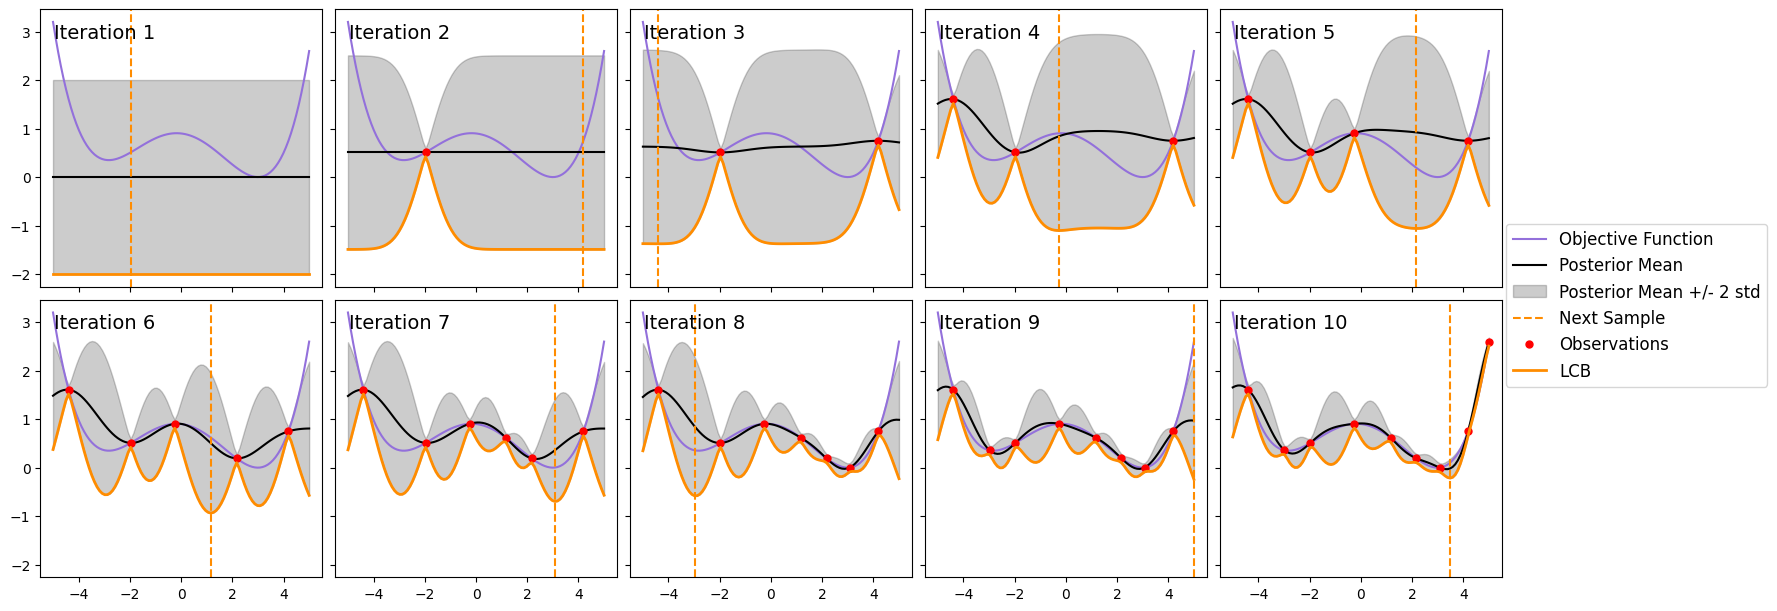

In [41]:

sz = 3
fig, ax = plt.subplots(2, 5, figsize=(5*sz, 2*sz), sharex=True, sharey=True, layout='constrained')
axes = ax.flatten()

for i in range(n_iterations):

    ax = axes[i]

    ax.plot(X_query, objective_function(X_query), label='Objective Function', color='mediumpurple')

    plot_gp_prediction(ax, predictions[i], color='black')
    ax.axvline(X_obs[i], color='darkorange', linestyle='--', label='Next Sample')
    ax.plot(X_obs[0:i], y_obs[0:i], 'ro', markersize=5, label='Observations')
    ax.plot(X_query, acquisition_functions[i], '-', label='LCB', color='darkorange', linewidth=2)

    ax.text(
        0.05,
        0.95,
        f"Iteration {i + 1}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
    )

# Put one legend outside on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.18, 0.5), fontsize='large');

#### Bayesian Optimization with Thompson sampling.

An interesting acquistion function that uses the properties of the Gaussian Process 
is Thompson sampling.

In Thompson sampling we draw a sample function from the GP and choose the optimal location according to 
that sample. So the GP posterior defines a distribution over functions conditioned on the data and 
we choose random one and select the optimum of that function. 

In [48]:
# Define the GP
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001))

objective_function = himmelblau  # Define the objective function

# Lists for observations
X_obs = []
y_obs = []

# Lists for storing things for visualization
predictions = []
acquisition_functions = []

# Settings:
n_iterations = 10
kappa = 2
X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions

for iteration in range(n_iterations):

    # Make predictions with the GP
    prediction = gp.predict(X_query) # Your code here
    predictions.append(prediction)

    # Construct the Thompson sampling acquisition function
    sample = gp.sample(X_query, n_samples=1).T
    acquisition_functions.append(sample)

    # Find the next point to sample - the minimum of the sampled function
    next_x = X_query[np.argmin(sample)]  # Your code here


    # Evaluate the function at the next point
    next_y = objective_function(next_x.reshape(1, -1)) # Your code here

    # Add new observation to the lists
    X_obs.append(next_x)
    y_obs.append(next_y)

    # Update the GP with the new observations
    gp.set_prior_mean(np.mean(y_obs))

    X_obs_arr = np.array(X_obs).reshape(-1, 1)
    y_obs_arr = np.array(y_obs).reshape(-1, 1)
    gp.condition(X_obs_arr, y_obs_arr)  # Update the GP with the new observations


Again we can plot each iteration of the BO.

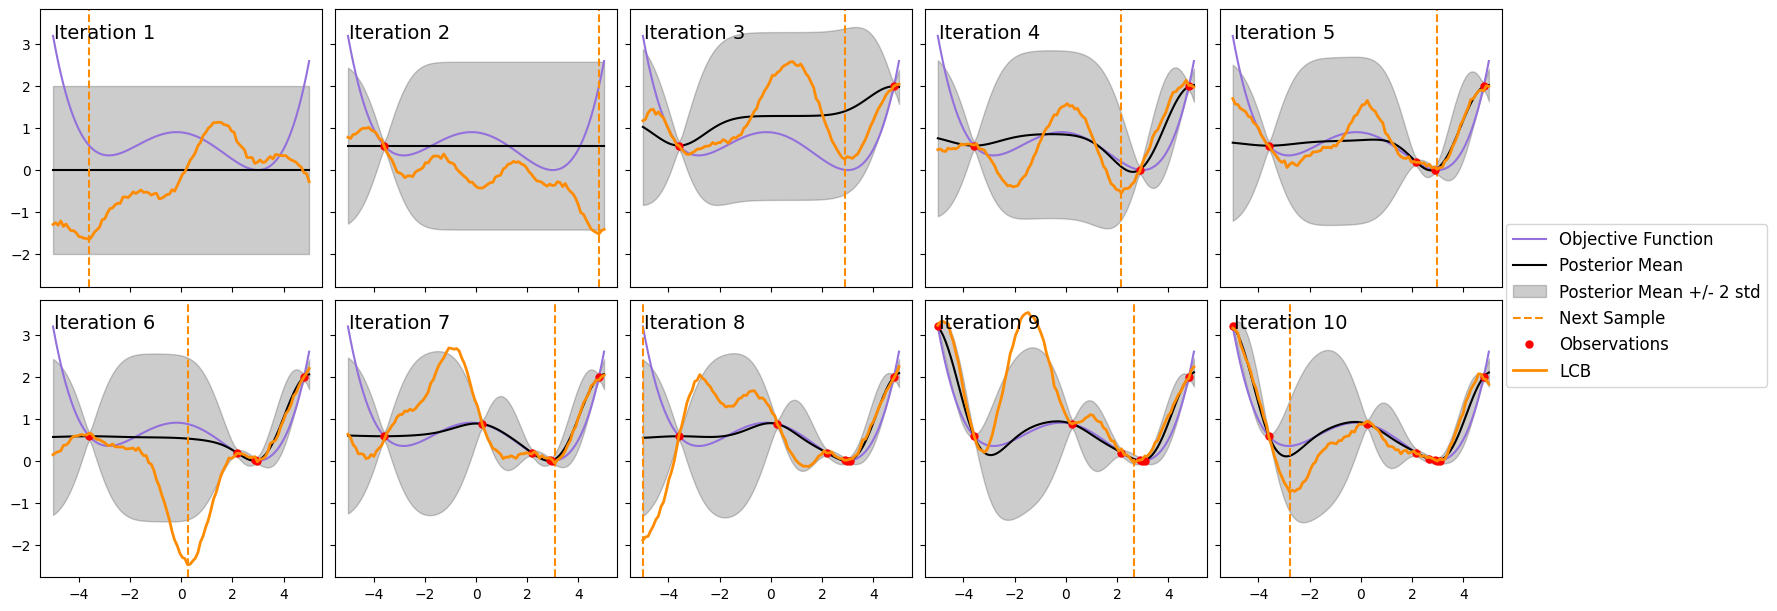

In [50]:
sz = 3
fig, ax = plt.subplots(2, 5, figsize=(5*sz, 2*sz), sharex=True, sharey=True, layout='constrained')
axes = ax.flatten()

for i in range(n_iterations):

    ax = axes[i]

    ax.plot(X_query, objective_function(X_query), label='Objective Function', color='mediumpurple')

    plot_gp_prediction(ax, predictions[i], color='black')
    ax.axvline(X_obs[i], color='darkorange', linestyle='--', label='Next Sample')
    ax.plot(X_obs[0:i], y_obs[0:i], 'ro', markersize=5, label='Observations')
    ax.plot(X_query, acquisition_functions[i], '-', label='LCB', color='darkorange', linewidth=2)

    ax.text(
        0.05,
        0.95,
        f"Iteration {i + 1}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
    )

# Put one legend outside on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.18, 0.5), fontsize='large');

### LML optimization (Maybe delete).

In [4]:
def get_optimized_kernel(kernel_func, bounds, X_obs, y_obs):
    from scipy.optimize import minimize

    def calculate_lml(x):
        kernel = kernel_func(x)
        gp = GaussianProcess(kernel=kernel, prior_mean=np.mean(y_obs))
        gp.condition(X_obs, y_obs)
        return gp.log_marginal_likelihood()
    

    log_bounds = np.log(np.array(bounds))
    initial_guess = np.random.uniform(low=log_bounds[:, 0], high=log_bounds[:, 1])
    initial_guess = np.exp(initial_guess)  # Convert back to the original

    result = minimize(
        lambda x: -calculate_lml(x),  # We minimize the negative log marginal likelihood
        x0=initial_guess,
        bounds=bounds,
        method='Nelder-Mead'
    )
    kernel = kernel_func(result.x)
    return kernel

In [5]:
# Define the GP
# bounds = [(0.1, 10), (1e-6, 5.0), (1e-3, 2.0)]  # Bounds for hyperparmaeters
bounds = [(10, 15), (0.25, 1.0), (1e-4, 1e-1)]  # Bounds for hyperparmaeters

kernel_func = lambda x: Constant(x[0]) * RadialBasis(length_scale=x[1]) + Noise(noise_level=x[2])
gp = GaussianProcess(kernel=Constant(15) * RadialBasis(length_scale=0.5) + Noise(0.001))

# Lists for observations
X_obs = []
y_obs = []

# Lists for storing things for visualization
predictions = []
acquisition_functions = []

# Settings:
n_iterations = 20
kappa = 2
X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions

for iteration in range(n_iterations):

    # Make predictions with the GP
    prediction = gp.predict(X_query) # Your code here
    predictions.append(prediction)

    # Construct the LCB acquisition function 
    # Remember that the 'prediction' object contains 'prediction.mean' and 'prediction.variance' -> std = sqrt(variance)
    lcb = prediction.mean - kappa * np.sqrt(prediction.variance) # Your code here
    acquisition_functions.append(lcb)

    # Find the next point to sample (the minimum of the LCB)
    # Use np.argmin to find the index of the minimum value in lcb
    next_x = X_query[np.argmin(lcb)] # Your code here

    # Evaluate the function at the next point
    next_y = rastrigin(next_x.reshape(1, -1))

    # Add new observation to the lists
    X_obs.append(next_x)
    y_obs.append(next_y)

    # Update the GP with the new observations
    X_obs_arr = np.array(X_obs).reshape(-1, 1)
    y_obs_arr = np.array(y_obs).reshape(-1, 1)

    kernel = get_optimized_kernel(kernel_func, bounds, X_obs_arr, y_obs_arr)
    gp = GaussianProcess(kernel=kernel, prior_mean=np.mean(y_obs))    


    gp.condition(X_obs_arr, y_obs_arr)  # Update the GP with the new observations


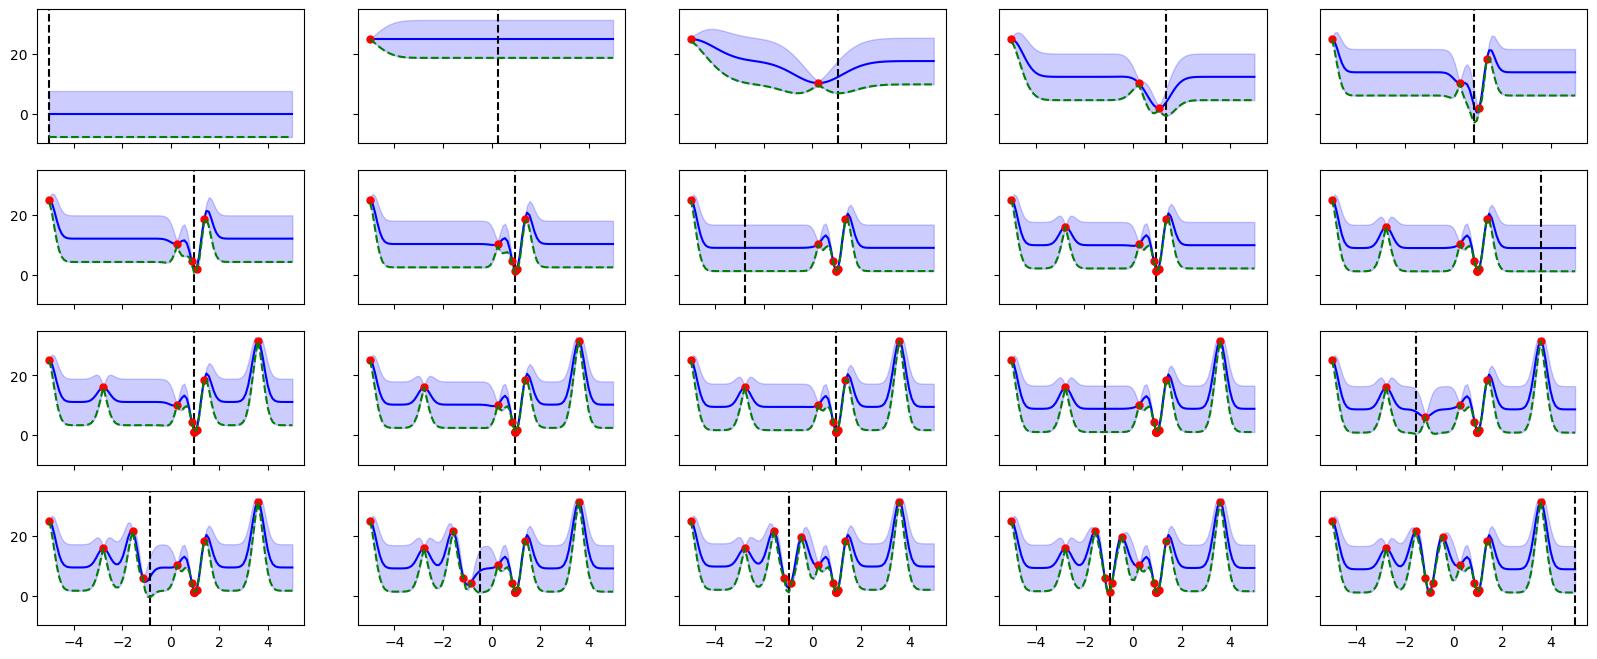

In [6]:
fig, ax = plt.subplots(4, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = ax.flatten()

for i in range(n_iterations):

    ax = axes[i]
    plot_gp_prediction(ax, predictions[i])
    ax.axvline(X_obs[i], color='k', linestyle='--', label='Next Sample')
    ax.plot(X_obs[0:i], y_obs[0:i], 'ro', markersize=5, label='Observations')
    ax.plot(X_query, acquisition_functions[i], 'g--', label='LCB')

    # axes[i].legend(fontsize=8)
    

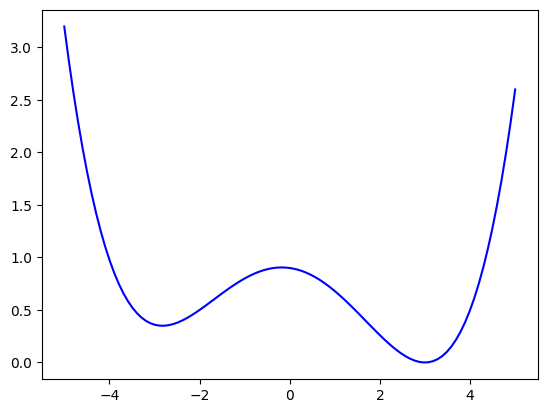

In [7]:

x = np.linspace(-5, 5, 100).reshape(-1, 1)
y = himmelblau(x)

plt.plot(x, y, label='Rosenbrock Function', color='blue')
